# NLP (Sentiment analysis) with LSTM

This notebook is originally from Francois Chollet's notebook accompanying his book "Deep Learning with Python".

I used it as a starting point for own experiments with word embeddings and modified it.

## Table of Contents

1. Word embeddings in general
2. Learning word embeddings with the Embedding layer
3. Using pre-trained word embeddings
4. Training a LSTM model

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.3'

## 1. Word embeddings in general

This notebook contains the second code sample found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

## 2. Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 

[...]


In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [3]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (both will be introduced in the next sections).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [4]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)


17465344/17464789 [==============================] - 3s 0us/step


In [13]:
print("shape of x_train=", x_train.shape)
print("shape of y_train=", y_train.shape)

print("shape of x_test=", x_test.shape)
print("shape of y_test=", y_test.shape)

NR_EXAMPLES_TO_SHOW = 15
for i in range(0,NR_EXAMPLES_TO_SHOW):
    print()
    print("Example sequence #", i)
    print("\tInput:",  x_train[i])
    print("\tOutput:", y_train[i])




shape of x_train= (25000, 20)
shape of y_train= (25000,)
shape of x_test= (25000, 20)
shape of y_test= (25000,)

Example sequence # 0
	Input: [  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32
   15   16 5345   19  178   32]
	Output: 1

Example sequence # 1
	Input: [  23    4 1690   15   16    4 1355    5   28    6   52  154  462   33
   89   78  285   16  145   95]
	Output: 0

Example sequence # 2
	Input: [1352   13  191   79  638   89    2   14    9    8  106  607  624   35
  534    6  227    7  129  113]
	Output: 0

Example sequence # 3
	Input: [   7 2804    5    4  559  154  888    7  726   50   26   49 7008   15
  566   30  579   21   64 2574]
	Output: 1

Example sequence # 4
	Input: [  15  595   13  784   25 3171   18  165  170  143   19   14    5 7224
    6  226  251    7   61  113]
	Output: 0

Example sequence # 5
	Input: [  10   10 1361  173    4  749    2   16 3804    8    4  226   65   12
   43  127   24    2   10   10]
	Output: 0

Example sequence # 6
	I

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 57us/step - loss: 0.6759 - acc: 0.6043 - val_loss: 0.6398 - val_acc: 0.6810
Epoch 2/10
20000/20000 [==============================] - 1s 45us/step - loss: 0.5657 - acc: 0.7428 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 1s 45us/step - loss: 

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is shit"_ and _"this movie is the shit"_ as being negative "reviews"). It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## 3. Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

### Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [16]:
import os

imdb_dir = 'large_movie_review_dataset/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [22]:
print("len of labels=",len(labels))
print("len of texts=",len(texts))

NR_EXAMPLES_TO_SHOW = 3
for i in range(0,NR_EXAMPLES_TO_SHOW):
    print()
    print("Example sequence #", i)
    print("\tLabel:",  labels[i])
    print("\tText:", texts[i])
    
print(labels)

len of labels= 25000
len of texts= 25000

Example sequence # 0
	Label: 0
	Text: Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.

Example sequence # 1
	Label: 0
	Text: Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [44]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 5000  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

print("Len of sequences is", len(sequences))
print("Example review as text:", texts[0])
print("Example review as integer sequence:", sequences[0])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)

print()
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

print()
print("Shape of x_train is", x_train.shape)
print("Shape of y_train is", y_train.shape)

print()
print("Shape of x_val is", x_val.shape)
print("Shape of y_val is", y_val.shape)

Len of sequences is 25000
Example review as text: Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.
Example review as integer sequence: [282, 171, 44

### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [45]:
glove_dir = 'glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


In [46]:
print('Found %s word vectors.' % len(embeddings_index))
for i,key in enumerate(embeddings_index):
    value = embeddings_index[key]
    print("Word", key, "-->", value)
    if i == 3:
        break

Found 400000 word vectors.
Word brockett --> [ 0.33578   -0.68282   -0.77117    0.17338   -0.084162  -0.34996
  0.20898    0.3376     0.15405    0.46283   -0.30397    0.12714
  0.054559  -0.35231    0.095936  -0.16224   -0.21077    0.18083
 -0.55152    0.37061   -0.46865   -0.20636   -0.11348   -0.34453
  0.10206    0.15897    0.077552  -0.14138   -0.16021    0.17821
 -0.32088   -0.20289    0.34438    0.15887    0.39497    0.95127
 -0.24971   -0.050084   0.03273    0.13508   -0.1225     0.49871
 -0.40989   -0.052672  -0.41463   -0.12683   -0.43082   -0.066442
  0.26695    0.66747    0.11949   -0.16577   -0.069714  -0.053098
 -0.26931    0.22682    0.43827    0.25237   -1.0767    -0.71395
  0.26846   -0.13479    0.8962    -0.26139   -0.39995   -0.71377
 -0.2004    -0.38557   -0.55952    0.56991   -0.064482   0.34024
  0.035591   0.13796    0.20172   -0.081919  -0.079089  -0.12896
  0.25096    0.58596   -0.461     -0.18261   -0.14723    0.099315
  0.77502   -0.13878    0.0020861 -0.30491


Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [47]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
print("Shape of embedding_matrix is", embedding_matrix.shape)

Shape of embedding_matrix is (10000, 100)


### Define a model

We will be using the same model architecture as before:

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [49]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [50]:
print("Shape of x_train is", x_train.shape)
print("Shape of y_train is", y_train.shape)

print()
print("Shape of x_val is", x_val.shape)
print("Shape of y_val is", y_val.shape)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Shape of x_train is (5000, 100)
Shape of y_train is (5000,)

Shape of x_val is (10000, 100)
Shape of y_val is (10000,)
Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 2s 355us/step - loss: 0.7280 - acc: 0.5054 - val_loss: 0.6933 - val_acc: 0.4933
Epoch 2/10
5000/5000 [==============================] - 2s 333us/step - loss: 0.6945 - acc: 0.5088 - val_loss: 0.6936 - val_acc: 0.4930
Epoch 3/10
5000/5000 [==============================] - 2s 328us/step - loss: 0.7016 - acc: 0.5320 - val_loss: 0.7689 - val_acc: 0.4935
Epoch 4/10
5000/5000 [==============================] - 2s 340us/step - loss: 0.6722 - acc: 0.5842 - val_loss: 0.7375 - val_acc: 0.4937
Epoch 5/10
5000/5000 [==============================] - 2s 349us/step - loss: 0.6141 - acc: 0.6648 - val_loss: 1.1038 - val_acc: 0.5045
Epoch 6/10
5000/5000 [==============================] - 2s 328us/step - loss: 0.5353 - acc: 0.7430 - val_loss: 0.7771 - val_acc: 0.5033
Epoch 7/10
5000/

Let's plot its performance over time:

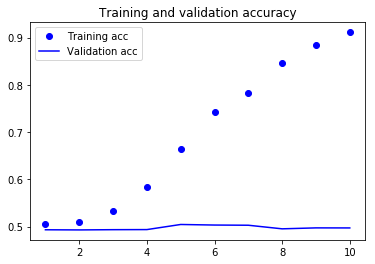

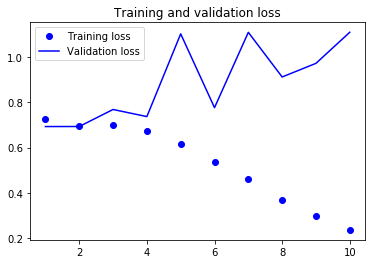

In [51]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [52]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/10
5000/5000 [==============================] - 4s 737us/step - loss: 0.6948 - acc: 0.4986 - val_loss: 0.6941 - val_acc: 0.4991
Epoch 2/10
5000/5000 [==============================] - 3s 698us/step - loss: 0

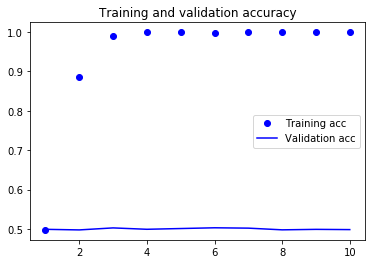

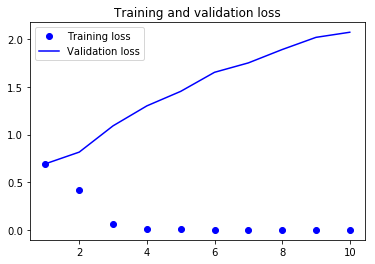

In [53]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [54]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [55]:
model.load_weights('pre_trained_glove_model.h5')
result = model.evaluate(x_test, y_test)
print(model.metrics_names)
print("result=",result)

25000/25000 [==============================] - 2s 71us/step
['loss', 'acc']
result= [1.183568579864502, 0.50452]


We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!

## 4. Training a LSTM model

The models used so far were just MLPs. Now let us try a LSTM model.

In [56]:
print("Shape of x_train is", x_train.shape)
print("Shape of y_train is", y_train.shape)

print()
print("Shape of x_val is", x_val.shape)
print("Shape of y_val is", y_val.shape)

Shape of x_train is (5000, 100)
Shape of y_train is (5000,)

Shape of x_val is (10000, 100)
Shape of y_val is (10000,)


In [61]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

print("max_words=", max_words)
print("embedding_dim=", embedding_dim)
print("input_length=", maxlen)

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

max_words= 10000
embedding_dim= 100
input_length= 100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=250,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/250
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6978 - acc: 0.4984 - val_loss: 0.6982 - val_acc: 0.4959
Epoch 2/250
5000/5000 [==============================] - 9s 2ms/step - loss: 0.6935 - acc: 0.5120 - val_loss: 0.6991 - val_acc: 0.4943
Epoch 3/250
5000/5000 [==============================] - 9s 2ms/step - loss: 0.6901 - acc: 0.5332 - val_loss: 0.7020 - val_acc: 0.4951
Epoch 4/250
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6870 - acc: 0.5400 - val_loss: 0.7061 - val_acc: 0.4951
Epoch 5/250
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6821 - acc: 0.5552 - val_loss: 0.6988 - val_acc: 0.4996
Epoch 6/250
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6773 - acc: 0.5680 - val_loss: 0.7005 - val_acc: 0.5018
Epoch 7/250
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6718 - acc: 0.5842 - val_loss: 0.7017 - val_acc: 0.5009
E

5000/5000 [==============================] - 11s 2ms/step - loss: 0.0327 - acc: 0.9924 - val_loss: 2.5873 - val_acc: 0.5078
Epoch 61/250
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0346 - acc: 0.9904 - val_loss: 2.5123 - val_acc: 0.5048
Epoch 62/250
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0293 - acc: 0.9940 - val_loss: 2.7183 - val_acc: 0.5020
Epoch 63/250
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0259 - acc: 0.9946 - val_loss: 2.6596 - val_acc: 0.5077
Epoch 64/250
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0277 - acc: 0.9922 - val_loss: 2.6975 - val_acc: 0.5056
Epoch 65/250
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0303 - acc: 0.9910 - val_loss: 2.7350 - val_acc: 0.5018
Epoch 66/250
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0308 - acc: 0.9918 - val_loss: 2.6880 - val_acc: 0.5063
Epoch 67/250
5000/5000 [==============================

Epoch 120/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0139 - acc: 0.9950 - val_loss: 3.5022 - val_acc: 0.5018
Epoch 121/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0162 - acc: 0.9964 - val_loss: 3.4123 - val_acc: 0.5077
Epoch 122/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0117 - acc: 0.9962 - val_loss: 3.3953 - val_acc: 0.5026
Epoch 123/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0099 - acc: 0.9972 - val_loss: 3.4752 - val_acc: 0.5021
Epoch 124/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0156 - acc: 0.9952 - val_loss: 3.5384 - val_acc: 0.5035
Epoch 125/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0115 - acc: 0.9966 - val_loss: 3.5336 - val_acc: 0.5068
Epoch 126/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0140 - acc: 0.9956 - val_loss: 3.5933 - val_acc: 0.4987
Epoch 127/250
5000/5000 [=========

5000/5000 [==============================] - 11s 2ms/step - loss: 0.0065 - acc: 0.9982 - val_loss: 3.8497 - val_acc: 0.5037
Epoch 180/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0073 - acc: 0.9970 - val_loss: 3.8609 - val_acc: 0.5047
Epoch 181/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0086 - acc: 0.9970 - val_loss: 3.8532 - val_acc: 0.5053
Epoch 182/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0070 - acc: 0.9974 - val_loss: 3.8426 - val_acc: 0.5068
Epoch 183/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0109 - acc: 0.9964 - val_loss: 3.8550 - val_acc: 0.5023
Epoch 184/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0080 - acc: 0.9982 - val_loss: 3.7610 - val_acc: 0.5046
Epoch 185/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0088 - acc: 0.9964 - val_loss: 3.8001 - val_acc: 0.5048
Epoch 186/250
5000/5000 [=======================

5000/5000 [==============================] - 11s 2ms/step - loss: 0.0049 - acc: 0.9982 - val_loss: 4.1565 - val_acc: 0.5028
Epoch 239/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0074 - acc: 0.9978 - val_loss: 4.1655 - val_acc: 0.5058
Epoch 240/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0082 - acc: 0.9974 - val_loss: 4.0994 - val_acc: 0.5067
Epoch 241/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0061 - acc: 0.9974 - val_loss: 4.1369 - val_acc: 0.5032
Epoch 242/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0043 - acc: 0.9980 - val_loss: 4.2031 - val_acc: 0.5029
Epoch 243/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0057 - acc: 0.9976 - val_loss: 4.2072 - val_acc: 0.4998
Epoch 244/250
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0109 - acc: 0.9954 - val_loss: 4.1876 - val_acc: 0.5040
Epoch 245/250
5000/5000 [=======================